In [1]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
from scipy.io.wavfile import write
from scipy.interpolate import interp1d

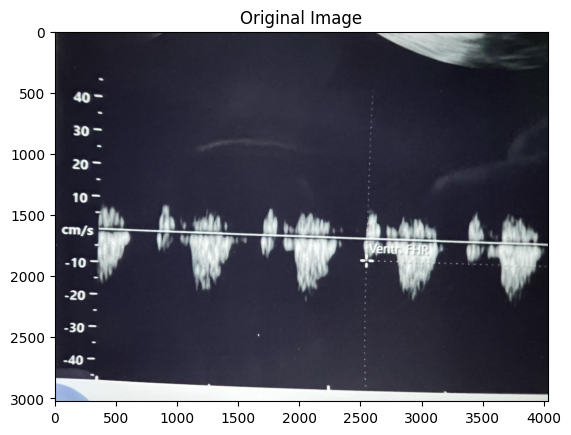

In [2]:
img = cv2.imread('./img/hb_2.jpg')
img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)

plt.title("Original Image")
plt.imshow(img)
plt.show()

In [3]:
def rotate_image(image, angle):

    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)

    return result


def crop_image(image):
    
    # return image[1500:2600, 420:2400]
    return image[1900:2700, 200:2000]

In [4]:
img = cv2.imread('./img/hb_2.jpg', cv2.IMREAD_GRAYSCALE)

ret, img = cv2.threshold(img, 145, 255, cv2.THRESH_BINARY)

img = rotate_image(img, 92)
img = crop_image(img)


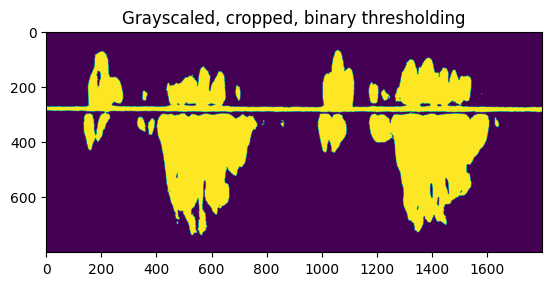

In [5]:
plt.title("Grayscaled, cropped, binary thresholding")
plt.imshow(img)
plt.show()

In [6]:
def extract_signal(img):
    """Estimate signal amplitude from image of sound wave.
    For each column of binarized image array, scan pixels
    and append indices to signal if current pixel
    and previous pixel have different values.

    Args:
        img (np.ndarray): numpy representation of image pixels

    Returns:
        (np.array): Indices of pixel value changes, estimating
            sound signal amplitude.
    """

    # init empty signal
    signal = np.empty((0, 2))

    for j in range(img.shape[1]): # cols
        for i in range(img.shape[0]): # rows
            prev = img[i-1, j]
            curr = img[i, j]

            if prev != curr: # if pixel value changes, append to output signal
                signal = np.append(signal, np.array([[j, img.shape[0] - i]]), axis=0)

    return signal



In [7]:
signal = extract_signal(img)

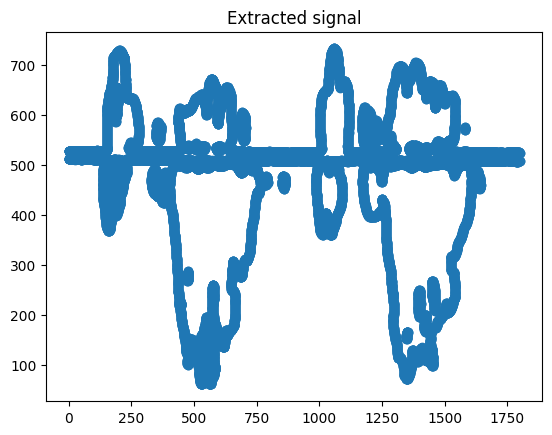

In [8]:
plt.title("Extracted signal")
plt.scatter(x=signal[:, 0], y=signal[:, 1])
plt.show()

In [9]:
# outlier removal with DBSCAN
dbs = DBSCAN(min_samples=10, eps=25)
dbs.fit(signal)

DBSCAN(eps=25, min_samples=10)

In [10]:
df = pd.DataFrame(signal, columns=['x', 'y'])
df['cluster'] = dbs.labels_

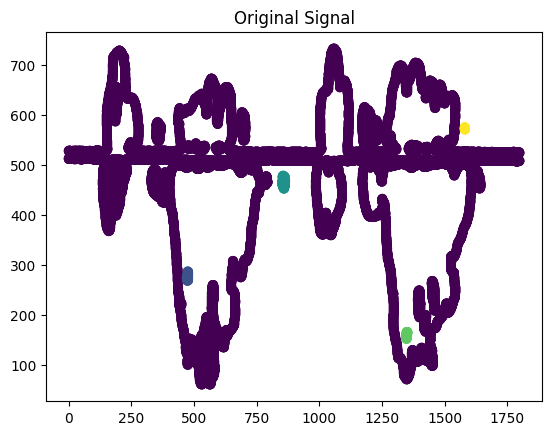

In [11]:
plt.title("Original Signal")
plt.scatter(x=df.x, y=df.y, c=df.cluster)
plt.show()

In [12]:
df = df.query("cluster == 0").reset_index(drop=True)

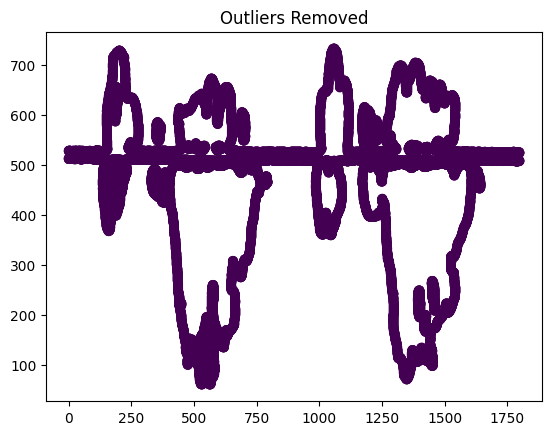

In [13]:
plt.title('Outliers Removed')
plt.scatter(x=df.x, y=df.y, c=df.cluster)
plt.show()

In [14]:
df['amplitude'] = MinMaxScaler().fit_transform(df['y'].to_numpy().reshape(-1,1))
processed_signal = df[['amplitude']].to_numpy()

for i in range(4):
    processed_signal = np.append(processed_signal, processed_signal, axis=0)

processed_signal.shape

(351072, 1)

In [15]:
interp = interp1d(x=range(processed_signal.shape[0]), y=processed_signal, kind='cubic', axis=0)

In [16]:
baby_bpm = 133
playback_rate = 44100
beats_in_photo = 2

curr_elapsed_time_minutes = (df.shape[0] / playback_rate) / 60
curr_bpm = 2 / curr_elapsed_time_minutes

slowdown_factor = curr_bpm / baby_bpm

print(f"Current BPM: {curr_bpm:0.2f}. Desired BPM: {baby_bpm}. Slowdown factor: {slowdown_factor:0.2f}.")

Current BPM: 241.18. Desired BPM: 133. Slowdown factor: 1.81.


In [17]:
adj_signal = []

for i in np.arange(0, processed_signal.shape[0] - 1, 1/slowdown_factor):
    adj_signal.append(interp(i))

adj_signal = np.array(adj_signal)

In [18]:
scaled = np.int16(adj_signal / np.max(np.abs(adj_signal)) * 32767)

In [19]:
ts = dt.datetime.now()
ts_str = ts.strftime("%Y%m%d%H%M%S")
write(f'audio/test_{ts_str}.wav', playback_rate, scaled)